# [GD10] 10-9. 프로젝트: CAM을 만들고 평가해 보자

## CAM 구현하기

### 1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [1]:
# def generate_cam(model, item):
#     cam_image = None
#     # TODO: generate cam image
#     return cam_image

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

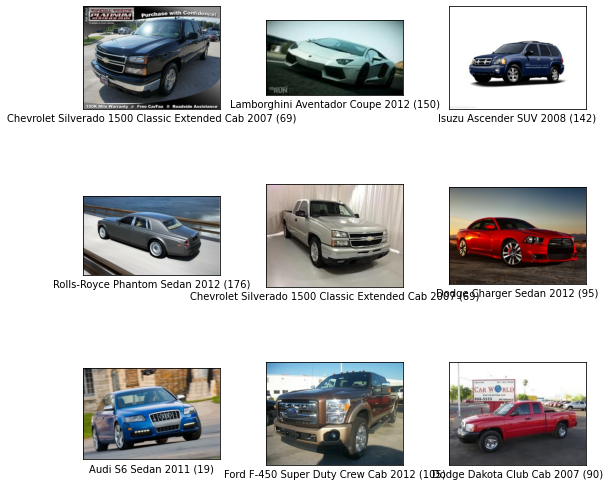

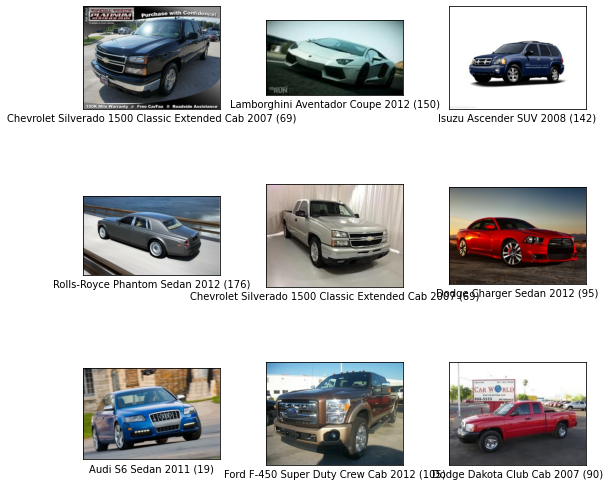

In [5]:
tfds.show_examples(ds_train, ds_info)

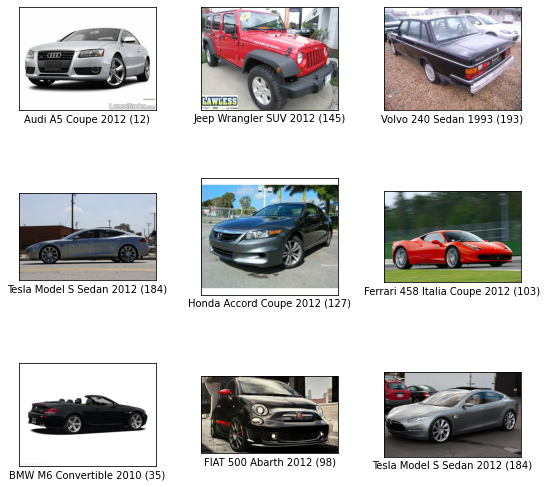

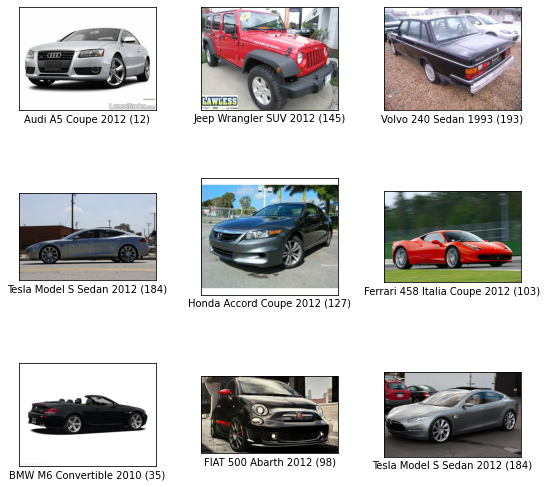

In [6]:
tfds.show_examples(ds_test, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [9]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [10]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [12]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
509/509 [==============================] - 80s 158ms/step - loss: 4.1415 - accuracy: 0.1713 - val_loss: 5.4407 - val_accuracy: 0.0055
Epoch 2/20
509/509 [==============================] - 92s 181ms/step - loss: 1.6409 - accuracy: 0.6428 - val_loss: 2.1050 - val_accuracy: 0.4898
Epoch 3/20
509/509 [==============================] - 80s 158ms/step - loss: 0.5813 - accuracy: 0.8938 - val_loss: 1.2795 - val_accuracy: 0.6602
Epoch 4/20
509/509 [==============================] - 81s 159ms/step - loss: 0.1750 - accuracy: 0.9802 - val_loss: 1.0801 - val_accuracy: 0.7138
Epoch 5/20
509/509 [==============================] - 81s 159ms/step - loss: 0.0641 - accuracy: 0.9963 - val_loss: 1.0187 - val_accuracy: 0.7283
Epoch 6/20
509/509 [==============================] - 82s 161ms/step - loss: 0.0388 - accuracy: 0.9984 - val_loss: 1.0056 - val_accuracy: 0.7307
Epoch 7/20
509/509 [==============================] - 81s 160ms/step - loss: 0.0275 - accuracy: 0.9984 - val_loss: 1.0040 - val_ac

In [14]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

13


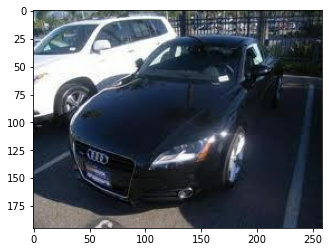

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [17]:
cam_model = tf.keras.models.load_model(cam_model_path)

### 2) 만든 함수로 CAM 이미지를 생성합시다.

In [18]:
# cam_image = generate_cam(cam_model, item)
# plt.imshow(cam_image)

In [19]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

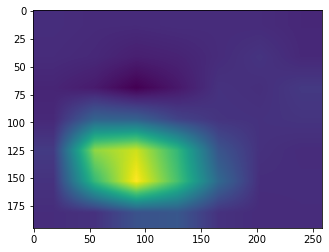

In [20]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 `visualize_cam_on_image()` 함수를 만들어보세요.  
  
* 참고: webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩 (https://webnautes.tistory.com/1245)

In [21]:
# def visualize_cam_on_image(image, cam_image):
#     # TODO: blend image
#     merged_image = None
#     return merged_image

In [22]:
# # visualize_cam_on_image() 함수 사용

# type(item['image'].numpy())

# origin_image = item['image'].numpy().astype(np.uint8)
# cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
# plt.imshow(blended_image)

In [23]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

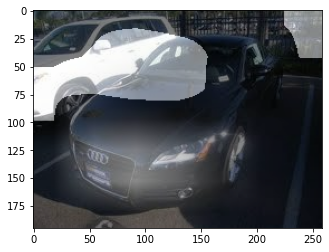

In [24]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

141


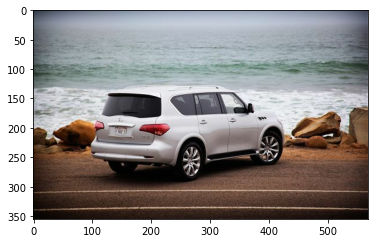

In [25]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

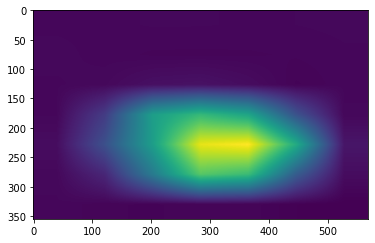

In [26]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

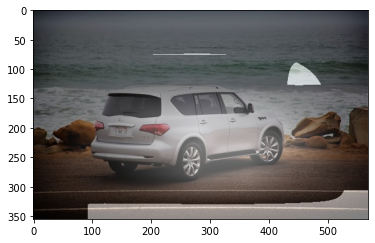

In [27]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

### 1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [28]:
# def generate_grad_cam(model, activation_layer, item):
#     grad_cam_image = None
#     # TODO: generate grad_cam_image

#     return grad_cam_image

In [29]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

### 2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

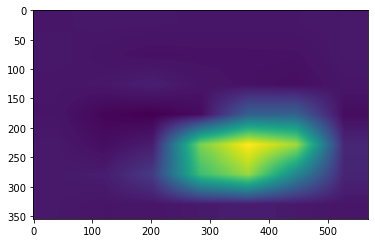

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

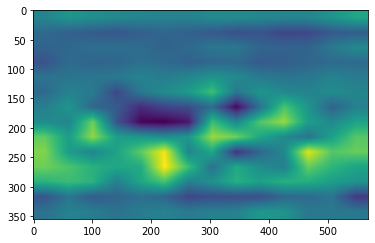

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

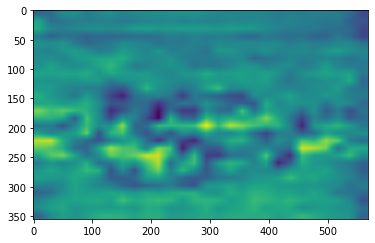

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

### 3) 위에서 만든 이미지 `visualize_cam_on_image()` 함수로 이미지를 시각화해 보세요.

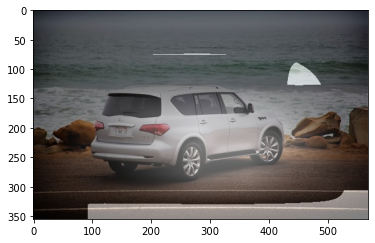

In [33]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)  # 이미지 시각화
plt.imshow(blended_image)

## 바운딩 박스 구하기

### 1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [34]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

### 2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

In [35]:
# CAM 바운딩 박스
image = copy.deepcopy(item['image'])
cam_rect = get_bbox(cam_image)
cam_rect

array([[ 54, 128],
       [526, 128],
       [526, 325],
       [ 54, 325]])

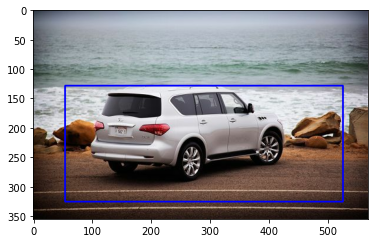

In [36]:
cam_image = cv2.drawContours(image,[cam_rect],0,(0,0,255),2)
plt.imshow(cam_image)

In [37]:
# Grad_CAM 바운딩 박스
image = copy.deepcopy(item['image'])
grad_cam_rect = get_bbox(grad_cam_image)
grad_cam_rect

array([[310, 258],
       [365, 244],
       [371, 270],
       [316, 283]])

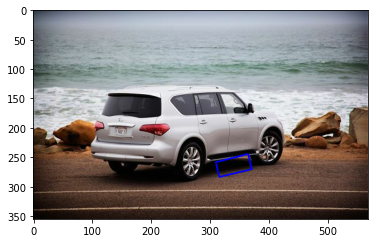

In [38]:
grad_cam_image = cv2.drawContours(image,[grad_cam_rect],0,(0,0,255),2)
plt.imshow(grad_cam_image)

## IoU 구하기

### 1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 `get_iou()` 함수를 만들어 주세요.

In [39]:
# def get_iou(gt_bbox, pred_bbox):
#     iou = None
#     # TODO: get iou between two bbox
#     return iou

In [40]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [41]:
# CAM 바운딩 박스
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_pred_bbox

[0.36056338028169016,
 0.09490333919156414,
 0.9154929577464789,
 0.9244288224956063]

In [42]:
# Grad_CAM 바운딩 박스
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
grad_cam_pred_bbox

[0.6873239436619718,
 0.5448154657293497,
 0.7971830985915493,
 0.6520210896309314]

### 2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [43]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [44]:
# CAM IoU 구하기
get_iou(cam_pred_bbox, item['bbox'])

0.580972249449627

In [45]:
# Grad_CAM IoU 구하기
get_iou(grad_cam_pred_bbox, item['bbox'])

0.042780076072553595